# BASIC CONFIGURATIONS

In [1]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_0',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000000
UpTime       = 3 days, 5:49:50
GitHash      = 0x69d8ea32115fd34d3ada6b89ad80fb3e63f2eda0
XilinxDnaId  = 0x400200000139d7204c80e045
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2022.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Thu 24 Aug 2023 11:52:58 AM PDT
Builder      = dnajjar
###################################################


In [3]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac
REGCTRL = ASICTOP.RegisterControlDualClock

In [4]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([3,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Root.Core.Si5345Pll.LoadCsvFile(): /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/EPixHRM320KPllConfig168Mhz.csv
Loaded. Waiting for lock...
Loading supply configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet register configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/

In [5]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)

In [6]:
#run some triggers and exercise lanes and locks
frames = 5000
rate = 1000

root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 5000
Stop Triggers command executed


In [7]:
#get locked lanes
root.getLaneLocks()

ASIC0: 0xffffff
ASIC1: 0xfffffe
ASIC2: 0x36ffff
ASIC3: 0xffffff


In [8]:
#Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))


ASIC0: 0x2
ASIC1: 0x1
ASIC2: 0xc90000
ASIC3: 0x0


In [21]:
#Enable data receivers and run some triggers
root.enableDataRcv(True)
root.enableAllAsics(True)
root.Trigger()

In [22]:
# Obtain descrambled single frame data from ASICs from DataReceiver. Data receiver is down sampled.
root.printDataReceiverStatus()
    
frame = [None for i in range(4)]
for asicIndex in range(4):
    frame[asicIndex] = getattr(root, f"DataReceiver{asicIndex}").Data.get()

Checkpoint: DataReceiver 0 has 0 frames
Checkpoint: DataReceiver 1 has 2 frames
Checkpoint: DataReceiver 2 has 2 frames
Checkpoint: DataReceiver 3 has 1 frames


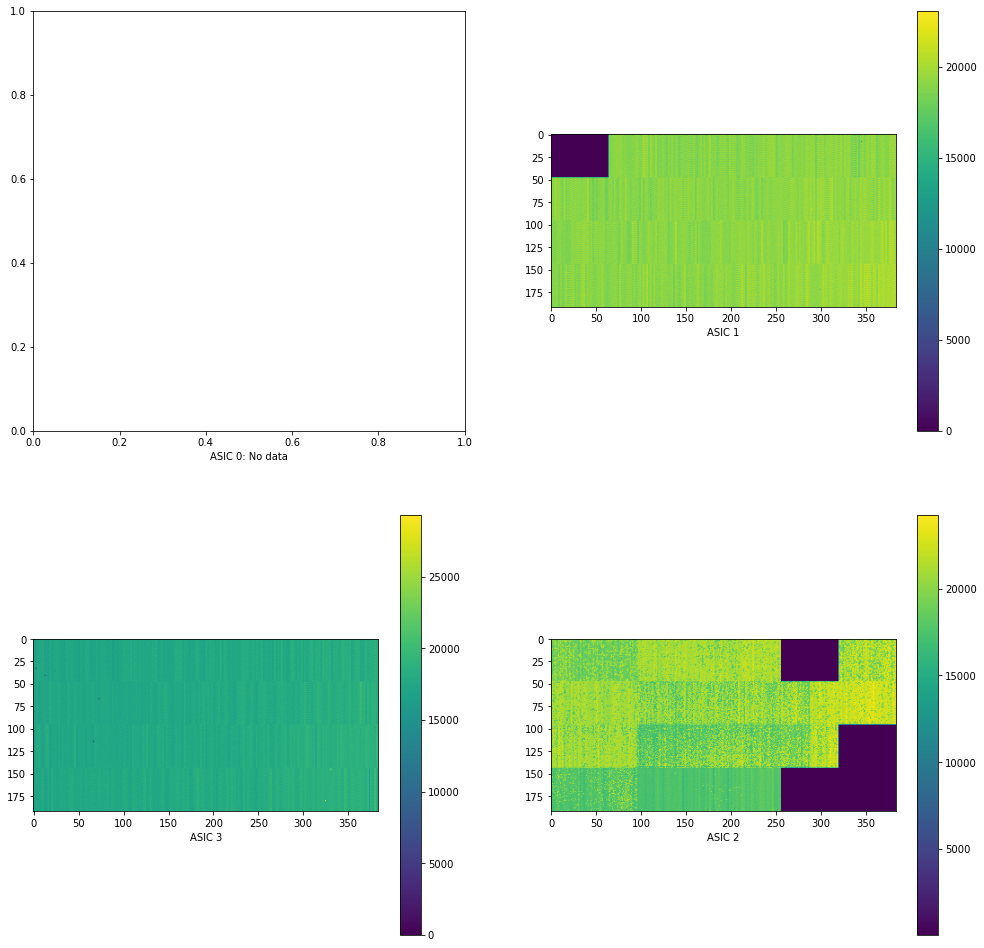

In [23]:
#plot image
plt.subplots(2,2,figsize=(17,17))
for asicIndex in range(root.numOfAsics):
    if asicIndex == 3 :
        plt.subplot(2,2,3)
    elif asicIndex == 2 :
        plt.subplot(2,2,4)
    else :
        plt.subplot(2,2,asicIndex+1)
    
    if np.shape(frame[asicIndex])[0] != 1 :
        plt.imshow(frame[asicIndex])
        plt.xlabel("ASIC {}".format(asicIndex))
        plt.colorbar()
    else :
        plt.xlabel("ASIC {}: No data".format(asicIndex))

# Control waveform delays

In [14]:
# helper functions
# clock speed is 168MHz. 1 tick is 0.006 us
def setSR0(width, delay) :
    REGCTRL.SR0Delay1.set(delay)
    REGCTRL.SR0Width1.set(width)
    print(f'SR0 Width set to {REGCTRL.SR0Width1_us.get():.3f}uS')
    print(f'SR0 Delay set to {REGCTRL.SR0Delay_us.get():.3f}uS')
    
def setAcq1(width, delay) :
    REGCTRL.AcqDelay1.set(delay)
    REGCTRL.AcqWidth1.set(width)
    print(f'Acq1 Width set to {REGCTRL.AcqWidth1_us.get():.3f}uS')
    print(f'Acq1 Delay set to {REGCTRL.AcqDelay1_us.get():.3f}uS')
    
def setAcq2(width, delay) :
    REGCTRL.AcqDelay2.set(delay)
    REGCTRL.AcqWidth2.set(width)
    print(f'Acq2 Width set to {REGCTRL.AcqWidth2_us.get():.3f}uS')
    print(f'Acq2 Delay set to {REGCTRL.AcqDelay2_us.get():.3f}uS')    

def setR0(width, delay) :
    REGCTRL.R0Delay.set(delay)
    REGCTRL.R0Width.set(width)
    print(f'R0 Width set to {REGCTRL.R0Width_us.get():.3f}uS')
    print(f'R0 Delay set to {REGCTRL.R0Delay_us.get():.3f}uS') 

    
def setSync(width, delay) :
    REGCTRL.SyncDelay.set(delay)
    REGCTRL.SyncWidth.set(width)
    print(f'Sync Delay set to {REGCTRL.SyncDelay_us.get():.3f}uS')     

In [19]:
# Steps = clock period of 168Mhz (5.95ns)
# Acq1 is 20us
# R0 after Acq1
# R0 Width set to 1.920uS
# SR0 needs to be launched after R0 delay + R0 width + alpha
AcqWidth = 3125
AcqDelay = 0
setAcq1(AcqWidth, AcqDelay)

R0Width = 300
R0Delay = 3125
setR0(R0Width, R0Delay)

SR0Width = 38000
SR0Delay = R0Width + R0Delay + 10
setSR0(SR0Width, SR0Delay)

Acq1 Width set to 20.000uS
Acq1 Delay set to 0.000uS
R0 Width set to 1.920uS
R0 Delay set to 20.000uS
SR0 Width set to 226.190uS
SR0 Delay set to 20.446uS


# Writing data to a rogue format file on full rate

In [24]:
root.enableDataRcv(False)
root.disableAndCleanAllFullRateDataRcv()
root.enableAllAsics(False)
root.enableDataDebug(False)

root.enableAsic(3, True)

ssdPath = "/u1/ePixHRM320k/acquisition"
filename = f"{ssdPath}/test.dat"
rate = 5000 # HZ
frames = 70000

root.acquireToFile(filename, frames, rate)

Acquisition started: filename: /u1/ePixHRM320k/acquisition/test.dat, rate: 5000, #frames:70000
Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 70000
Stop Triggers command executed
Received on channel 0 0 frames...
Received on channel 1 0 frames...
Received on channel 2 0 frames...
Received on channel 3 70000 frames...
Waiting for file to close...
Acquisition complete and file closed
